In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

recentPop = pd.read_csv('./data/boston pop.csv')
oldPop = pd.read_csv('./data/2015-19 census data.csv')
open_space = pd.read_csv('./data/Open_Space.csv')
#sort = pop.sort_values(by='muni_id')
locations = ['Mattapan', 'Roxbury', 'Dorchester', 'Charlestown', 'East Boston', 'Hyde Park', 'Jamaica Plain', 'Mission Hill', 
             'Roslindale', 'South Boston', 'South End', 'West Roxbury', 'Fenway', 'Longwood', 'Allston', 'Back Bay', 'Brighton', 'West End']

totPop2020 = []
whitePop2020 = []
afAmeriPop2020 = []
hisPop2020 = []
asianPop2020 = []
otherPop2020 = []

totPop2015 = []
whitePop2015 = []
afAmeriPop2015 = []
hisPop2015 = []
asianPop2015 = []
otherPop2015 = []

greenspaces = []
existing_greenways = []
in_progress_greenways = []


existingGreenway = ['Emerald', 'Southwest Coordidor', 'East Boston Greenway', 'Charles River', 'South Bay Harbor Trail', 'Neponset', 'Day Boulevard']
in_progressGreenway = ['Neponset', 'Charlesgate Greenway', 'Malcolm X Boulevard', 'Commonwealth Avenue Mall', 'Seaver Street']

# Filtering existing_greenway_data
existing_greenway_data = open_space[open_space['SITE_NAME'].str.contains('|'.join(existingGreenway), case=False) | open_space['ADDRESS'].str.contains('|'.join(existingGreenway), case=False)]

# Filtering in_progress_greenway_data
in_progress_greenway_data = open_space[open_space['SITE_NAME'].str.contains('|'.join(in_progressGreenway), case=False) | open_space['ADDRESS'].str.contains('|'.join(in_progressGreenway), case=False)]

""" 
Change the "mutli-district" entry in the DISTRICT column to Dorchester/Mattapan/Hyde Park for Neponset River Reservation 1, and change it 
to Allston/Fenway/Brighton/Back Bay/West End for Charles River Reservation
"""
def replace_district(row):
    if row['SITE_NAME'] == 'Neponset River Reservation I':
        return 'Dorchester/Mattapan/Hyde Park'
    elif row['SITE_NAME'] == 'Charles River Reservation':
        return 'Allston/Fenway/Brighton/Back Bay/West End'
    else:
        return row['DISTRICT']
    
existing_greenway_data['DISTRICT'] = existing_greenway_data.apply(replace_district, axis=1)
in_progress_greenway_data['DISTRICT'] = in_progress_greenway_data.apply(replace_district, axis=1)
open_space['DISTRICT'] = open_space.apply(replace_district, axis=1)

#filter out places that are not considered greenways
#open_space = open_space.loc[(open_space["TypeLong"] != "Cemeteries & Burying Grounds") 
                            #& (open_space["TypeLong"] != "Malls, Squares & Plazas")]

for location in locations:
    # Initialize total acres for the current location
    total_acres = 0
    greenway_acres = 0
    in_progress_greenway_acres = 0
    
    # Iterate over each row in the DataFrame
    for index, row in open_space.iterrows():
        # Check if the desired location is present in any substring after splitting by '/'
        if location in row['DISTRICT'].split('/') or location in row['DISTRICT'].split('-'):
            # Add the acres for the current row to the total acres
            total_acres += row['ACRES']
    
    for index, row in existing_greenway_data.iterrows():
        if location in row['DISTRICT'].split('/'):
            greenway_acres += row['ACRES']

    for index, row in in_progress_greenway_data.iterrows():
        if location in row['DISTRICT'].split('/'):
            in_progress_greenway_acres += row['ACRES']
    
    # Append the total acres for the current location to the greenspaces list
    greenspaces.append(total_acres)
    existing_greenways.append(greenway_acres)
    in_progress_greenways.append(in_progress_greenway_acres)

    white2020 = int(recentPop[recentPop['Area'] == location]['White alone'])
    afAmeri2020 = int(recentPop[recentPop['Area'] == location]['Black or African American alone'])
    his2020 = int(recentPop[recentPop['Area'] == location]['Hispanic or Latino'])
    asian2020 = int(recentPop[recentPop['Area'] == location]['Asian'])
    other2020 = int(recentPop[recentPop['Area'] == location]['Other Races'])

    whitePop2020.append(white2020)
    afAmeriPop2020.append(afAmeri2020)
    hisPop2020.append(his2020)
    asianPop2020.append(asian2020)
    otherPop2020.append(other2020)
    totPop2020.append(int(recentPop[recentPop['Area'] == location]['Total']))

    white2015 = int(oldPop[oldPop['Area'] == location]['White Alone'])
    afAmeri2015 = int(oldPop[oldPop['Area'] == location]['Black/African-American'])
    his2015 = int(oldPop[oldPop['Area'] == location]['Hispanic'])
    asian2015 = int(oldPop[oldPop['Area'] == location]['Asian alone'])
    other2015 = int(oldPop[oldPop['Area'] == location]['Other Races'])
    total2015 = white2015 + afAmeri2015 + his2015 + asian2015 + other2015

    whitePop2015.append(white2015)
    afAmeriPop2015.append(afAmeri2015)
    hisPop2015.append(his2015)
    asianPop2015.append(asian2015)
    otherPop2015.append(other2015)
    totPop2015.append(total2015)

focus = ['Mattapan', 'Roxbury', 'Dorchester'] 

diff = [x - y for x, y in zip(totPop2020, totPop2015)]

existing_greenways_boolean = [1 if x != 0 else 0 for x in existing_greenways]
any_greenway_boolean = [1 if (x != 0 or y != 0) else 0 for (x, y) in zip(existing_greenways, in_progress_greenways)]


""" 
I want to make a new dataframe here with the first column being the districts we have greenway data for + locations, and there are 4 features (for now): 
- greenway acres / total greenspace acres
- greenway acres / district total population
- greenway acres
- 1 if there is a greenway in that district, 0 if there isnt

Difficulites: 
- have to figure out which districts "multi-district" greenways are in... have to include in the report that the total acreage is not fully accurate in those cases, it is an overestimate.
- not all locations have corresponding population data, so we can only do the 2nd feature if there is any, and we can't compare to the displacement if there isn't either

Limitations:
- not enough data to train any kind of model on, otherwise we could have a class that is like "positive population growth" and then use that to predict for our focus locations if adding a greenspace would help
    or even how much greenspace would need to be added for it to help.
""" 
# Create dictionaries
data = {
    'locations': locations,
    'greenspace acres': greenspaces,
    'existing greenway acres': existing_greenways,
    'in progress greenway acres': in_progress_greenways,
    'presence of existing greenways': existing_greenways_boolean,
    'presence of any greenway': any_greenway_boolean,
    'pop': totPop2020,
    'displacement': diff
}

# Create DataFrame
greenway_features = pd.DataFrame(data)

# Calculate additional features
greenway_features['greenway to greenspace ratio'] = greenway_features['existing greenway acres'] / greenway_features['greenspace acres']
greenway_features['greenway to population ratio'] = greenway_features['existing greenway acres'] / greenway_features['pop']

# Set location as index
greenway_features.set_index('locations', inplace=True)

greenway_features.to_csv('./data/greenway features.csv', index=False)


C:\Users\alvis\AppData\Local\Temp/ipykernel_14508/3351708502.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  existing_greenway_data['DISTRICT'] = existing_greenway_data.apply(replace_district, axis=1)
C:\Users\alvis\AppData\Local\Temp/ipykernel_14508/3351708502.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_progress_greenway_data['DISTRICT'] = in_progress_greenway_data.apply(replace_district, axis=1)


In [30]:
# data extracted from https://www.boston.gov/government/cabinets/boston-public-health-commission/health-data
health_data = greenway_features.drop(['in progress greenway acres', 'presence of existing greenways', 'presence of any greenway', 'pop', 'displacement', 'greenway to greenspace ratio', 'greenway to population ratio'], axis=1)
health_data = health_data.drop('Mission Hill')
health_data = health_data.drop('Longwood')

health_data['Life Expectancy'] = [77.3, 77.8, 78.0, 82.7, 79.5, 81.7, 80.8, 80.2, 78.3, 81.9, 79.6, 82.4, 81.0, 82.8, 81.0, 82.8]
health_data['Asthma in Adults (%)'] = [11.6, 14.4, 13.3, 11.7, 9.1, 11.3, 9.3, 13.2, 8.7, 17.4, 8.0, 9.1, 9.0, 7.9, 9.0, 7.9]
health_data['Suicide Rate (per 100,000)'] = [0.0, 8.2, 7.3, 0.0, 4.7, 7.6, 7.3, 5.2, 4.7, 4.5, 13.1, 6.9, 7.3, 6.1, 7.3, 6.1]
health_data['Depression in Adults (%)'] = [19.5, 18.7, 17.2, 19.7, 15.4, 14.6, 11.2, 16.5, 9.9, 13.7, 9.9, 10.9, 18.7, 9.3, 18.7, 9.3]
health_data['Low Birthweight (%)'] = [11.8, 9.7, 11.3, 6.2, 7.2, 9.3, 6.9, 7.6, 6.7, 6.4, 7.7, 9.9, 7.3, 6.2, 7.3, 6.2]
health_data['Diabetes in Adults (%)'] = [15.4, 15.5, 12.8, 7.1, 12.0, 13.8, 4.6, 7.3, 5.2, 8.5, 5.8, 3.7, 5.5, 5.3, 5.5, 5.3]
health_data['Suicide Rate (%)'] = health_data['Suicide Rate (per 100,000)'] / 1000
health_data = health_data.drop(['Suicide Rate (per 100,000)'], axis=1)
health_data.head(18)

,greenspace acres,existing greenway acres,Life Expectancy,Asthma in Adults (%),Depression in Adults (%),Low Birthweight (%),Diabetes in Adults (%),Suicide Rate (%)
locations,,,,,,,,
Mattapan,418.602035,183.501520,77.3,11.6,19.5,11.8,15.4,0.0000
Roxbury,568.753876,0.000000,77.8,14.4,18.7,9.7,15.5,0.0082
Dorchester,589.746275,183.501520,78.0,13.3,17.2,11.3,12.8,0.0073
Charlestown,65.911247,0.000000,82.7,11.7,19.7,6.2,7.1,0.0000
East Boston,255.831831,4.744064,79.5,9.1,15.4,7.2,12.0,0.0047
Hyde Park,934.322590,189.041674,81.7,11.3,14.6,9.3,13.8,0.0076
Jamaica Plain,743.955790,0.000000,80.8,9.3,11.2,6.9,4.6,0.0073
Roslindale,209.741797,0.000000,80.2,13.2,16.5,7.6,7.3,0.0052
South Boston,208.251699,16.850704,78.3,8.7,9.9,6.7,5.2,0.0047


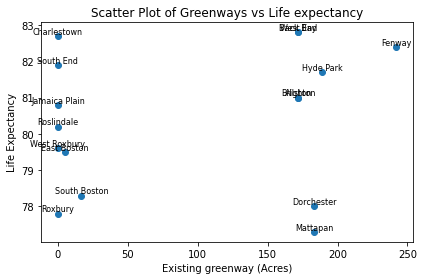

Correlation coefficient: 0.21337863402541443


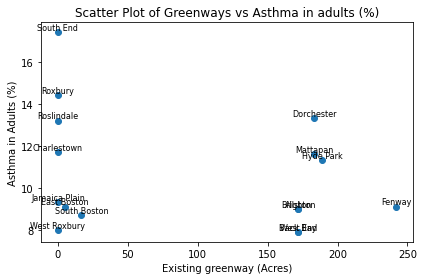

Correlation coefficient: -0.3008024209115852


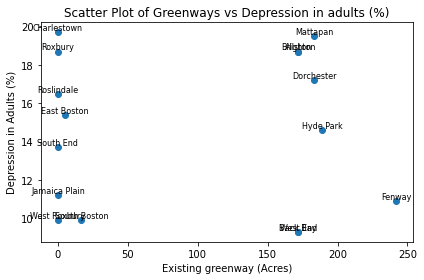

Correlation coefficient: 0.005337651376182639


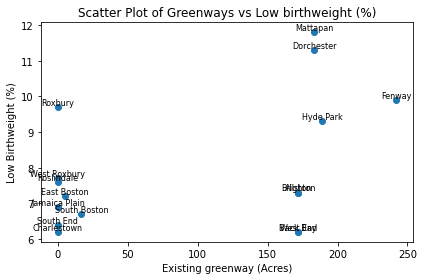

Correlation coefficient: 0.4356536099738873


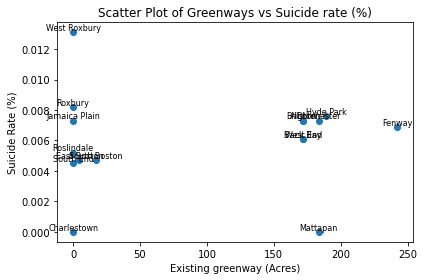

Correlation coefficient: 0.018581113869694688


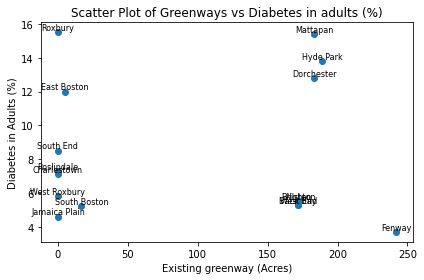

Correlation coefficient: -0.0034859072163973825


In [31]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

features = ['Life Expectancy', 'Asthma in Adults (%)', 'Depression in Adults (%)', 'Low Birthweight (%)', 'Suicide Rate (%)', 'Diabetes in Adults (%)']
for feature in features:    
    plt.scatter(health_data['existing greenway acres'], health_data[feature])
    plt.title(f'Scatter Plot of Greenways vs {feature.capitalize()}')
    plt.xlabel('Existing greenway (Acres)')
    plt.ylabel(feature)
    
    for index, row in health_data.iterrows():
        plt.text(row['existing greenway acres'], row[feature], str(index), fontsize=8, ha='center', va='bottom')
    

    correlation_coefficient, _ = pearsonr(health_data['existing greenway acres'], health_data[feature])
    plt.tight_layout()
    plt.show()
    print("Correlation coefficient:", correlation_coefficient)


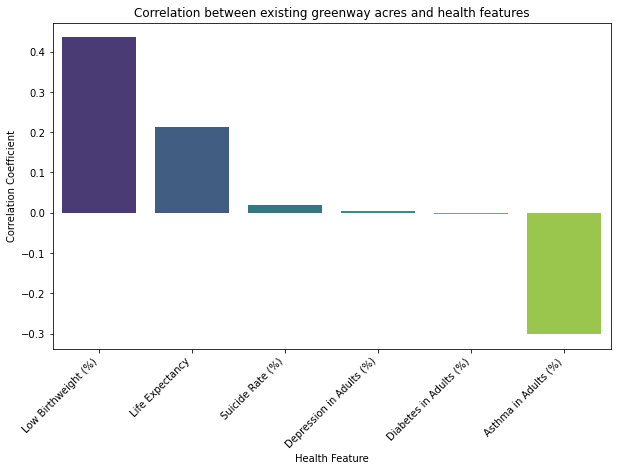

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt


columns_to_remove = ['greenspace acres', 'existing greenway acres']
health_data_subset = health_data.drop(columns=columns_to_remove)
target_column = 'existing greenway acres'
correlations = health_data_subset.corrwith(health_data[target_column])
correlations = correlations.sort_values(ascending=False)
plt.figure(figsize=(10, 6)) 
sns.barplot(x=correlations.index, y=correlations.values, palette='viridis')
plt.title('Correlation between {} and health features'.format(target_column))
plt.xlabel('Health Feature')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()


In [33]:
# data extracted from https://www.boston.gov/sites/default/files/file/document_files/2017/03/go_boston_2030_-_3_boston_today_spreads.pdf and https://www.bostonplans.org/getattachment/f719d8d1-9422-4ffa-8d11-d042dd3eb37b
transit_data = greenway_features.drop(['greenspace acres', 'existing greenway acres', 'in progress greenway acres', 'presence of existing greenways', 'presence of any greenway', 'pop', 'greenway to greenspace ratio', 'greenway to population ratio'], axis=1)
transit_data['Workers Taking Transit (%)'] = [34, 42.1, 36.9, 26, 55.7, 21.4, 38.1, 39.8, 25.7, 36.9, 31, 14.5, 27, 19.8, 38.3, 26.2, 30.7, 23.4]
transit_data['Non Family Households (%)'] = [5, 6, 11, 12, 12, 6, 18, 26, 8, 24, 16, 6, 26, 10, 38, 14, 29, 15]
transit_data['Households With At Least One Vehicle (%)'] = [75, 55, 69, 77, 63, 86, 77, 58, 85, 72, 59, 90, 33, 33, 48, 51, 69, 44]

transit_data.head(18)

,displacement,Workers Taking Transit (%),Non Family Households (%),Households With At Least One Vehicle (%)
locations,,,,
Mattapan,-2819,34.0,5,75
Roxbury,372,42.1,6,55
Dorchester,-4718,36.9,11,69
Charlestown,-770,26.0,12,77
East Boston,-4197,55.7,12,63
Hyde Park,-4752,21.4,6,86
Jamaica Plain,-852,38.1,18,77
Mission Hill,132,39.8,26,58
Roslindale,-435,25.7,8,85


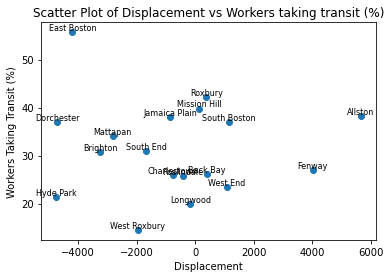

Correlation coefficient: -0.05466012835196248


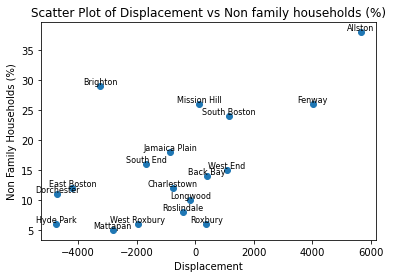

Correlation coefficient: 0.6024038470969112


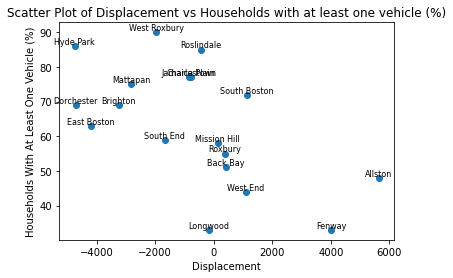

Correlation coefficient: -0.5915720140437521


In [34]:
features = ['Workers Taking Transit (%)', 'Non Family Households (%)', 'Households With At Least One Vehicle (%)']
for feature in features:    
    plt.scatter(transit_data['displacement'], transit_data[feature])
    plt.title(f'Scatter Plot of Displacement vs {feature.capitalize()}')
    plt.xlabel('Displacement')
    plt.ylabel(feature)
    for index, row in transit_data.iterrows():
        plt.text(row['displacement'], row[feature], str(index), fontsize=8, ha='center', va='bottom')
    correlation_coefficient, _ = pearsonr(transit_data['displacement'], transit_data[feature])
    plt.show()
    print("Correlation coefficient:", correlation_coefficient)

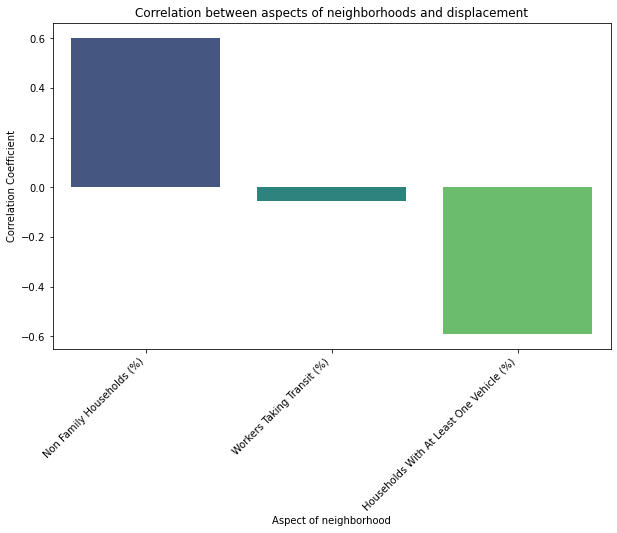

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

target_column = 'displacement'
correlations = transit_data.corrwith(transit_data[target_column])
correlations = correlations.sort_values(ascending=False)
correlations = correlations.drop(index=target_column)
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.index, y=correlations.values, palette='viridis')
plt.title('Correlation between aspects of neighborhoods and {}'.format(target_column))
plt.xlabel('Aspect of neighborhood')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()


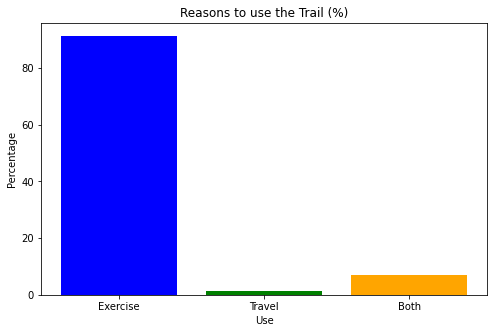

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# data from https://link.springer.com/article/10.1007/s10900-011-9530-z#Tab5
data = {
    'Category': ['Exercise', 'Travel', 'Both'],
    'Count': [1027, 17, 80]
}

df = pd.DataFrame(data)
total_count = df['Count'].sum()
df['Percentage'] = (df['Count'] / total_count) * 100
plt.figure(figsize=(8, 5))
plt.bar(df['Category'], df['Percentage'], color=['blue', 'green', 'orange'])
plt.xlabel('Use')
plt.ylabel('Percentage')
plt.title('Reasons to use the Trail (%)')
plt.show()